In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
from wwf.vision import timm
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [3]:
torch.cuda.set_device(0)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs224wwf_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=128,num_workers=0)

In [10]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.740184,0.446383,0.742308,0.728814,0.771795,0.749689,0.819671,01:50


Better model found at epoch 0 with f1_score value: 0.7496886674968868.


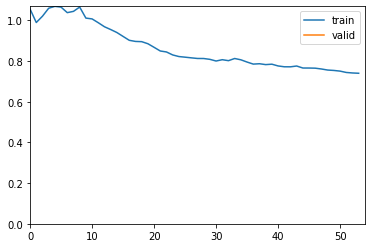

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.535718,0.279436,0.755128,0.723596,0.825641,0.771257,0.843596,01:54
1,0.502425,0.238433,0.801282,0.772622,0.853846,0.811206,0.871111,01:52
2,0.451668,0.238930,0.779487,0.744395,0.851282,0.794258,0.863886,01:52
3,0.407431,0.183466,0.808974,0.787589,0.846154,0.815822,0.889211,01:53
4,0.380163,0.195805,0.782051,0.782051,0.782051,0.782051,0.859826,01:54
5,0.365808,0.172134,0.782051,0.759434,0.825641,0.791155,0.873662,01:51
6,0.332642,0.155141,0.783333,0.796247,0.761538,0.778506,0.879645,01:49
7,0.316898,0.136175,0.793590,0.795866,0.789744,0.792793,0.883731,01:51
8,0.304515,0.156832,0.784615,0.808333,0.746154,0.776000,0.863353,01:53
9,0.281066,0.145643,0.789744,0.778325,0.810256,0.793970,0.876312,01:53


Better model found at epoch 0 with f1_score value: 0.7712574850299401.


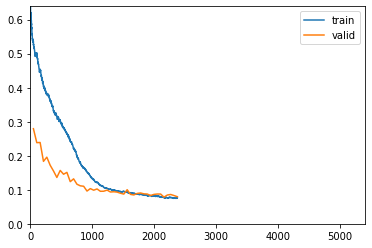

Better model found at epoch 1 with f1_score value: 0.8112058465286235.
Better model found at epoch 3 with f1_score value: 0.8158220024721878.
Better model found at epoch 17 with f1_score value: 0.8287581699346406.
Better model found at epoch 18 with f1_score value: 0.8354430379746836.
Better model found at epoch 23 with f1_score value: 0.8451443569553806.
Better model found at epoch 25 with f1_score value: 0.8522875816993465.
Better model found at epoch 30 with f1_score value: 0.85752688172043.
Better model found at epoch 35 with f1_score value: 0.8593548387096773.
Better model found at epoch 39 with f1_score value: 0.8642951251646903.
Better model found at epoch 43 with f1_score value: 0.8682795698924731.
No improvement since epoch 39: early stopping


In [11]:
learn.fine_tune(100,base_lr=1e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=128,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9564554898093359.


(#6) [0.07320453971624374,0.882564127445221,0.9107929515418502,0.8482051282051282,0.8783855549654805,0.9564554898093359]

# 384

In [7]:
import torch
torch.cuda.set_device(1)
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs384wwf_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=16,num_workers=0)

In [10]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('resnetrs224wwf_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.212970,0.195793,0.789744,0.767773,0.830769,0.798030,0.859681,02:13


Better model found at epoch 0 with f1_score value: 0.7980295566502463.


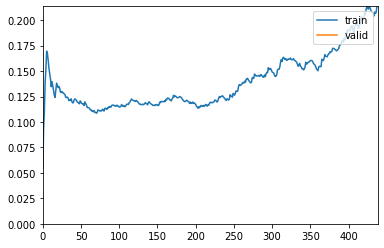

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.121530,0.098588,0.829487,0.842667,0.810256,0.826144,0.912755,02:34
1,0.102226,0.089610,0.847436,0.844784,0.851282,0.848020,0.929250,02:33
2,0.109067,0.089577,0.856410,0.875676,0.830769,0.852632,0.924513,02:34
3,0.099543,0.090345,0.838462,0.814286,0.876923,0.844444,0.929083,02:33
4,0.103839,0.085055,0.862821,0.869452,0.853846,0.861578,0.936292,02:33
5,0.099382,0.089696,0.861538,0.943396,0.769231,0.847458,0.937755,02:33
6,0.092207,0.084770,0.855128,0.830549,0.892308,0.860321,0.939237,02:34
7,0.095067,0.083313,0.853846,0.868984,0.833333,0.850785,0.938813,02:34
8,0.088532,0.085123,0.864103,0.869792,0.856410,0.863049,0.940325,02:33
9,0.100209,0.083816,0.862821,0.881402,0.838462,0.859396,0.938540,02:34


Better model found at epoch 0 with f1_score value: 0.8261437908496733.


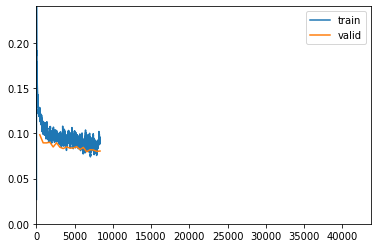

Better model found at epoch 1 with f1_score value: 0.8480204342273308.
Better model found at epoch 2 with f1_score value: 0.8526315789473685.
Better model found at epoch 4 with f1_score value: 0.8615782664941785.
Better model found at epoch 8 with f1_score value: 0.8630490956072352.
Better model found at epoch 14 with f1_score value: 0.8722580645161291.
No improvement since epoch 14: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=32,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9637517422748192.


(#6) [0.06593360006809235,0.9005128145217896,0.8972533062054934,0.9046153846153846,0.9009193054136874,0.9637517422748192]

# 512

In [18]:
import torch
torch.cuda.set_device(1)
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrs512wwf_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [21]:
learn = timm.timm_learner(dls,'resnetrs50',metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('resnetrs384wwf_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0020892962347716093)

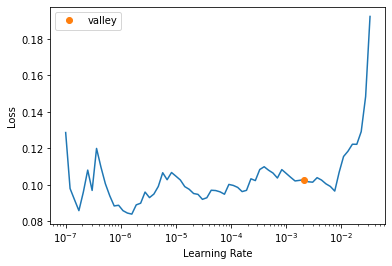

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.107975,0.092150,0.862821,0.900850,0.815385,0.855989,0.933675,03:51


Better model found at epoch 0 with f1_score value: 0.8559892328398385.


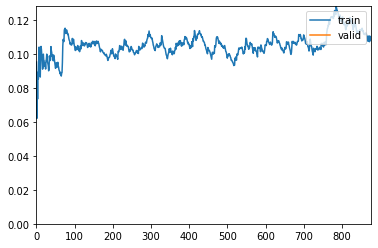

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.108527,0.085474,0.857692,0.884298,0.823077,0.852590,0.936226,06:03
1,0.098119,0.082102,0.852564,0.891738,0.802564,0.844804,0.943373,06:02
2,0.100798,0.086461,0.847436,0.897361,0.784615,0.837209,0.940381,05:57
3,0.098192,0.084843,0.848718,0.884181,0.802564,0.841398,0.941259,05:59
4,0.086882,0.084524,0.870513,0.887399,0.848718,0.867628,0.937548,06:00
5,0.090437,0.086261,0.862821,0.898592,0.817949,0.856376,0.936673,05:59
6,0.101042,0.081644,0.862821,0.837709,0.900000,0.867738,0.943649,05:52
7,0.104672,0.093408,0.844872,0.889855,0.787179,0.835374,0.929020,04:38
8,0.097958,0.084890,0.871795,0.898352,0.838462,0.867374,0.942429,05:39
9,0.091748,0.081990,0.870513,0.863980,0.879487,0.871665,0.943494,05:43


Better model found at epoch 0 with f1_score value: 0.8525896414342629.


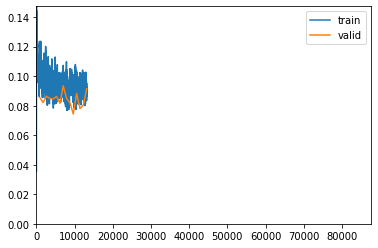

Better model found at epoch 4 with f1_score value: 0.8676277850589778.
Better model found at epoch 6 with f1_score value: 0.8677379480840544.
Better model found at epoch 9 with f1_score value: 0.8716645489199492.
Better model found at epoch 10 with f1_score value: 0.8961201501877346.
No improvement since epoch 10: early stopping


In [24]:
learn.fine_tune(100,base_lr=1e-3)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9627387245233399.


(#6) [0.06818683445453644,0.8969230651855469,0.8901209677419355,0.9056410256410257,0.8978139298423996,0.9627387245233399]